In [1]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = np.load('dataset_for_exercise_62/nn_nnn_clusters_6.npz')

def get_graph(index, data, cutoff=2.5, box_size=10):
    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)


In [3]:
def get_max_xval(graphs, model, extra_offset=2.0):
    max_val = None
    for graph in graphs:
        xy = model(graph)
        xs = None
        if type(xy) is tuple:
            xs = xy[0]
        else:
            xs = xy
        if max_val is None:
            max_val = torch.max(xs)
        else:
            max_now = torch.max(xs)
            if max_now >= max_val:
                max_val = max_now
    return max_val + extra_offset

def get_min_xval(graphs, model, extra_offset=2.0):
    min_val = None
    for graph in graphs:
        xy = model(graph)
        xs = None
        if type(xy) is tuple:
            xs = xy[0]
        else:
            xs = xy
        if min_val is None:
            min_val = torch.min(xs)
        else:
            min_now = torch.min(xs)
            if min_now <= min_val:
                min_val = min_now
    return min_val - extra_offset

def get_cmap_colors(graphs, model, cmap=mpl.cm.brg, Nsteps=10, max_val=None, min_val=None, min_offset=1.0, max_offset=1.0):
    if min_val is None:
        min_val = get_min_xval(graphs, model, min_offset)
    if max_val is None:
        max_val = get_max_xval(graphs, model, max_offset)
    bounds = torch.linspace(min_val, max_val, Nsteps)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cnorm, cmap

def plot(ax, graph, cmap, cnorm, model, **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        y_val = graph.y
        cons1 = positions[edge_indices[0]]
        cons2 = positions[edge_indices[1]]
        ax.set_xlim([torch.min(cons1[:,0])-0.5, torch.max(cons1[:,0])+0.5])
        ax.set_ylim([torch.min(cons1[:,1])-0.5, torch.max(cons1[:,1])+0.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")
        if model is None:
            for position, x_val in zip(positions, graph.x):
                ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=30, **plot_kwargs)
                ax.annotate(text=f"{round(x_val.item(),1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)
        else:
            for position, x_val in zip(positions, model(graph.x, edge_indices, torch.tensor([0], dtype=torch.long))[0]):
                ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=30, **plot_kwargs)
                ax.annotate(text=f"{round(x_val.item(),1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)
        ax.annotate(text=f"{round(y_val.item(), 3)}", xy=(torch.min(cons1[:,0])-0.1, torch.min(cons1[:,1])-0.1), fontsize=12, bbox=dict(boxstyle="round", fc="w"))

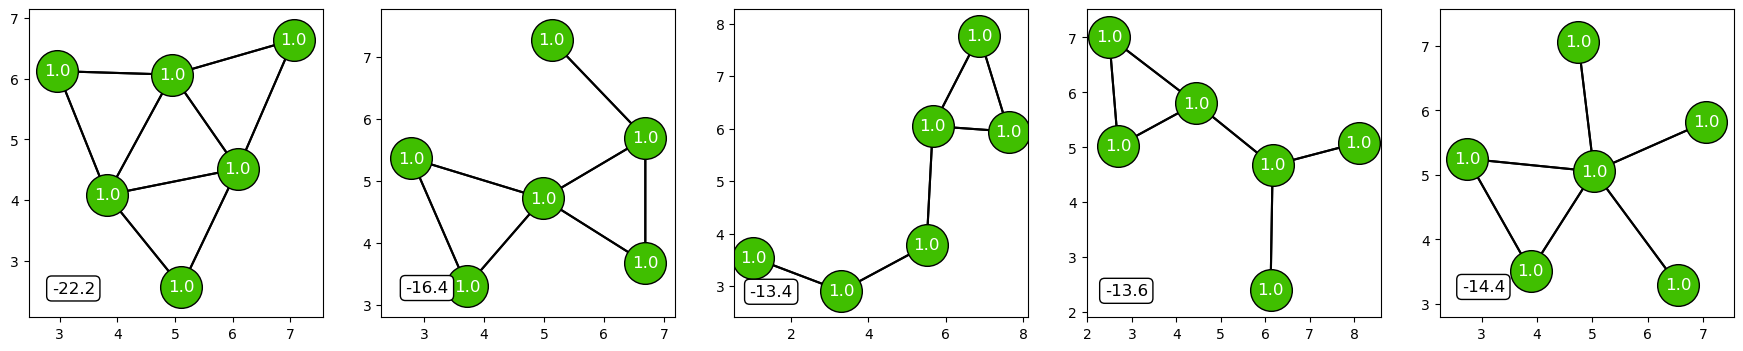

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(22,4))
graphs = [get_graph(index=i, data=data) for i in range(44)]
cnorm, cmap = get_cmap_colors(graphs=graphs[0], model=None, max_val=2.0, min_val=-6.0)
indices = np.arange(0, len(graphs), 10)
for index, ax in zip(indices, axs):
    plot(ax=ax, graph=graphs[index], cmap=cmap, cnorm=cnorm, model=None)

In [5]:
class AggrPhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_out, bias=True)
        self.phi = torch.nn.Linear(d_in+d_out, d_out, bias=True)
        self.aggr = SumAggregation()

    def forward(self, x, edge_index, batch):
        psi_of_x_j = self.propagate(edge_index, x=x)
        x = self.phi(torch.hstack((x, psi_of_x_j)))
        y = self.aggr(x, batch)
        return x,y # return both local and global prediction

    def message(self, x_j):
        return self.psi(x_j)

def train_model(model, train_loader, optimizer, loss_func=torch.nn.MSELoss(), epochs=1000):
    for epoch in range(epochs):
        total_loss = 0
        total_N = 0
        for graphs in train_loader:
            optimizer.zero_grad()
            #print(graphs.y)
            #print(aggr_phi_psi_gnn.forward(graphs.x, graphs.edge_index, graphs.batch)[1])
            loss = loss_func(model.forward(graphs.x, graphs.edge_index, graphs.batch)[1], graphs.y.view(-1,1))
            loss.backward()
            optimizer.step()
            N = len(graphs)
            total_N += N
            total_loss += loss.item() * N

        avg_loss = total_loss / total_N
        if (epoch+1) % 250 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

In [6]:
gcnn = AggrPhiPsiGNN(1,1)
train_loader = DataLoader(graphs, batch_size=5)
optimizer = torch.optim.Adam(params=gcnn.parameters(), lr=1e-3)
train_model(model=gcnn, train_loader=train_loader, optimizer=optimizer, epochs=2500)

Epoch 250/2500, Loss: 3.0979
Epoch 500/2500, Loss: 2.0172
Epoch 750/2500, Loss: 0.8940
Epoch 1000/2500, Loss: 0.2493
Epoch 1250/2500, Loss: 0.0856
Epoch 1500/2500, Loss: 0.0802
Epoch 1750/2500, Loss: 0.0802
Epoch 2000/2500, Loss: 0.0802
Epoch 2250/2500, Loss: 0.0802
Epoch 2500/2500, Loss: 0.0802


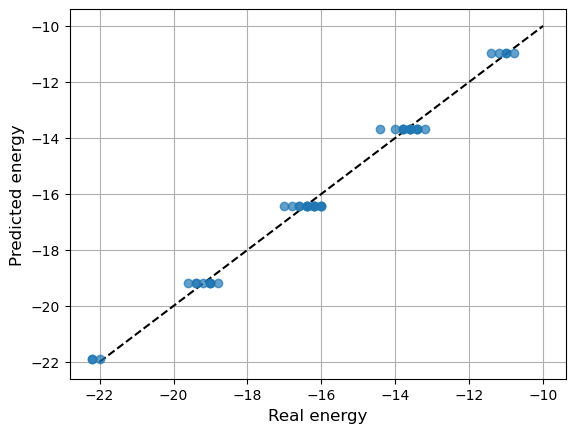

In [7]:
fig, ax = plt.subplots()
ax.grid()
xs = np.linspace(-22,-10, 100)
ax.plot(xs, xs, '--',c="k")
ax.set_xlabel("Real energy", fontsize=12)
ax.set_ylabel("Predicted energy", fontsize=12)
with torch.no_grad():
    for graphs in train_loader:
        x_vals, y_vals = gcnn.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
        ax.plot(graphs.y, y_vals, 'o', c='C0', alpha=0.7)

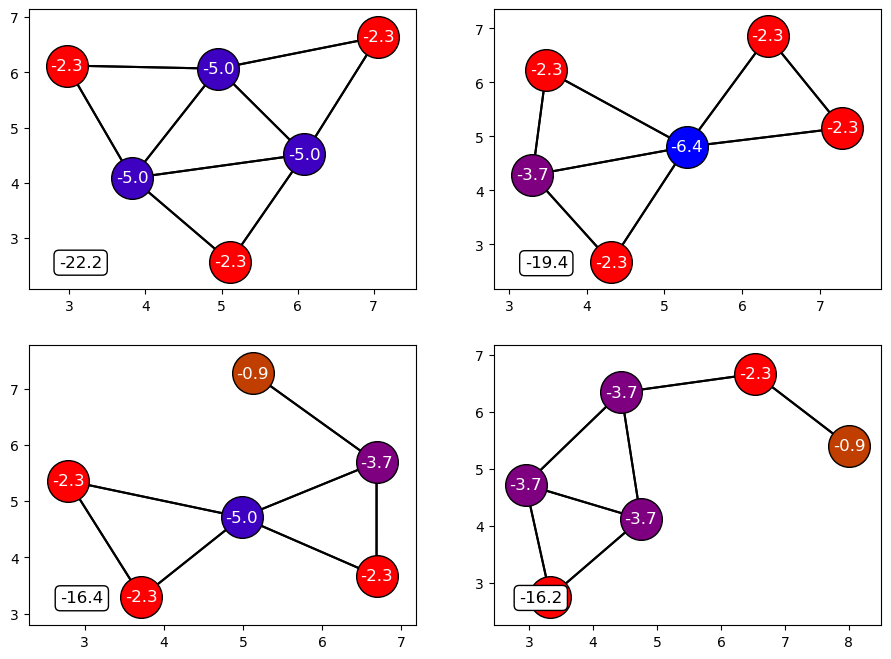

In [8]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
cnorm, cmap = get_cmap_colors(graphs=None, model=None, max_val=2.0, min_val=-6.0)
for graphs, ax in zip(train_loader, axs.flatten()):
    graph = graphs[0]
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=gcnn)

In [9]:
class GCNN_layered(MessagePassing):
    def __init__(self, d_in, d_out, num_layers=2, aggr='add'):
        super().__init__(aggr=aggr)
        self.psis = torch.nn.ParameterList()
        self.phis = torch.nn.ParameterList()
        for num_layer in range(num_layers):
            self.psis.append(torch.nn.Linear(d_in, d_out, bias=True))
            self.phis.append(torch.nn.Linear(d_in+d_out, d_out, bias=True))
        self.aggr = SumAggregation()

    def forward(self, x, edge_index, batch):
        for psi, phi in zip(self.psis, self.phis):
            psi_of_x_j = self.propagate(edge_index, x=x, psi=psi)
            x = phi(torch.hstack((x, psi_of_x_j)))
        y = self.aggr(x, batch)
        return x,y # return both local and global prediction

    def message(self, x_j, psi):
        return psi(x_j)

In [10]:
graphs = [get_graph(index=i, data=data) for i in range(44)]
gcnn = GCNN_layered(1,1)
train_loader = DataLoader(graphs, batch_size=5)
optimizer = torch.optim.Adam(params=gcnn.parameters(), lr=1e-3)
train_model(model=gcnn, train_loader=train_loader, optimizer=optimizer, epochs=2500)

Epoch 250/2500, Loss: 0.0004
Epoch 500/2500, Loss: 0.0004
Epoch 750/2500, Loss: 0.0004
Epoch 1000/2500, Loss: 0.0003
Epoch 1250/2500, Loss: 0.0005
Epoch 1500/2500, Loss: 0.0003
Epoch 1750/2500, Loss: 0.0005
Epoch 2000/2500, Loss: 0.0000
Epoch 2250/2500, Loss: 0.0005
Epoch 2500/2500, Loss: 0.0001


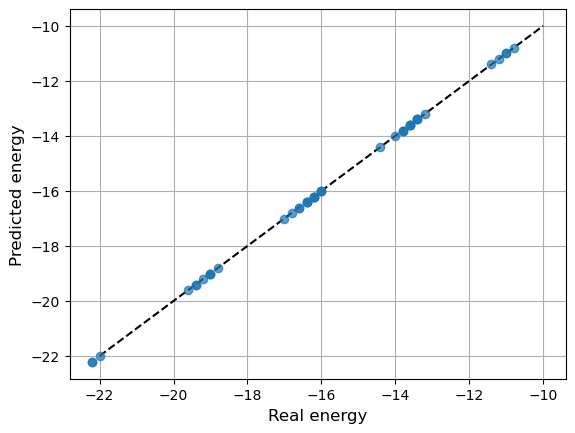

In [12]:
fig, ax = plt.subplots()
ax.grid()
xs = np.linspace(-22,-10, 100)
ax.plot(xs, xs, '--',c="k")
ax.set_xlabel("Real energy", fontsize=12)
ax.set_ylabel("Predicted energy", fontsize=12)
with torch.no_grad():
    for graphs in train_loader:
        x_vals, y_vals = gcnn.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
        ax.plot(graphs.y, y_vals, 'o', c='C0', alpha=0.7)

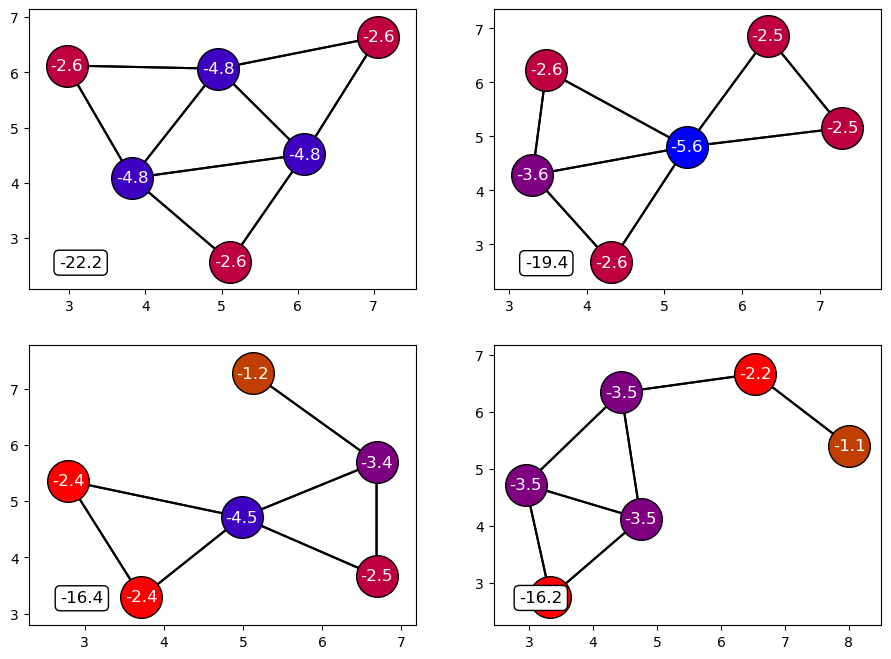

In [13]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
cnorm, cmap = get_cmap_colors(graphs=None, model=None, max_val=2.0, min_val=-6.0)
for graphs, ax in zip(train_loader, axs.flatten()):
    graph = graphs[0]
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=gcnn)

In [14]:
def get_loaders(graph_list, test_indices=[23, 36, 21, 19, 9, 39, 42, 3, 0], batch_sizes=(5,1), shuffle=True):
    train_batch, test_batch = batch_sizes
    test_graphs = []
    train_graphs = []
    for i in range(len(graph_list)):
        if i in test_indices:
            test_graphs.append(graph_list[i])
        else:
            train_graphs.append(graph_list[i])
    return DataLoader(train_graphs, batch_size=train_batch, shuffle=shuffle), DataLoader(test_graphs, batch_size=test_batch, shuffle=True)

def get_data_and_loaders(MODIFIED=True, batch_sizes=(5,1), shuffle=True, return_only_loaders=True):
    if MODIFIED:
        data = np.load('dataset_for_exercise_62/modified_tb_clusters_6.npz')
    else:
        data = np.load('dataset_for_exercise_62/tight_binding_clusters_6.npz')
    graphs = [get_graph(index=i, data=data) for i in range(44)]
    train_loader, test_loader = get_loaders(graph_list=graphs, batch_sizes=batch_sizes, shuffle=shuffle)
    if return_only_loaders == True:
        return train_loader, test_loader
    else:
        return train_loader, test_loader, graphs

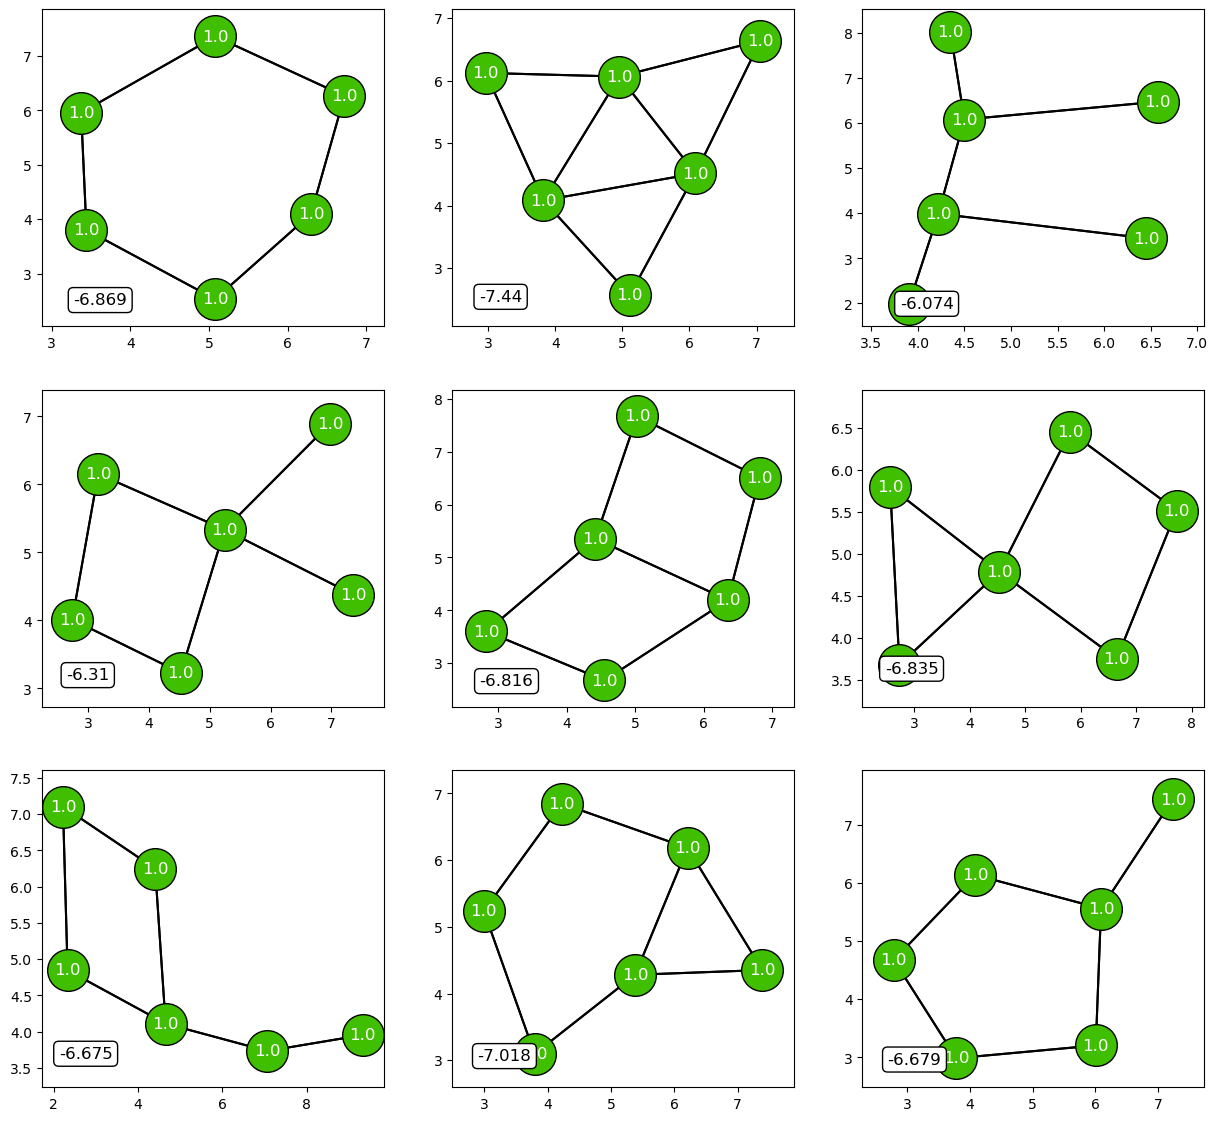

In [15]:
train_loader, test_loader = get_data_and_loaders(MODIFIED=True)
fig, axs = plt.subplots(3,3, figsize=(15,14))
cnorm, cmap = get_cmap_colors(graphs=None, model=None, max_val=2.0, min_val=-6.0)
for graph, ax in zip(test_loader, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=None)

In [16]:
data_loaders_total = [get_data_and_loaders(MODIFIED=True), get_data_and_loaders(MODIFIED=False)]
models = [GCNN_layered(1,1, num_layers=2) for i in range(2)]
labels = ["Training on MODIFIED Data:", "Training on UN-MODIFIED Data:"]
for model, data_loaders, label in zip(models, data_loaders_total, labels):
    print(label)
    train_loader, test_loader = data_loaders
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, epochs=2500)
    print("")

Training on MODIFIED Data:
Epoch 250/2500, Loss: 0.6815
Epoch 500/2500, Loss: 0.2140
Epoch 750/2500, Loss: 0.0573
Epoch 1000/2500, Loss: 0.0382
Epoch 1250/2500, Loss: 0.0381
Epoch 1500/2500, Loss: 0.0375
Epoch 1750/2500, Loss: 0.0373
Epoch 2000/2500, Loss: 0.0368
Epoch 2250/2500, Loss: 0.0339
Epoch 2500/2500, Loss: 0.0265

Training on UN-MODIFIED Data:
Epoch 250/2500, Loss: 0.1809
Epoch 500/2500, Loss: 0.0715
Epoch 750/2500, Loss: 0.0430
Epoch 1000/2500, Loss: 0.0408
Epoch 1250/2500, Loss: 0.0372
Epoch 1500/2500, Loss: 0.0338
Epoch 1750/2500, Loss: 0.0314
Epoch 2000/2500, Loss: 0.0293
Epoch 2250/2500, Loss: 0.0292
Epoch 2500/2500, Loss: 0.0284



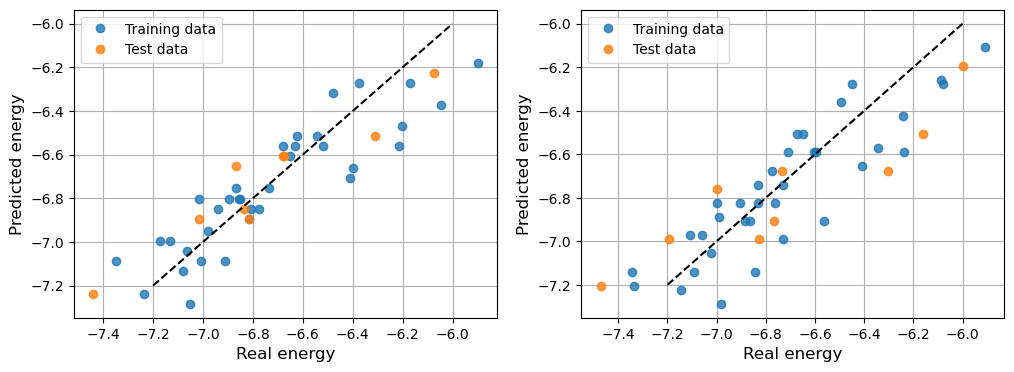

In [17]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
xs = np.linspace(-7.2,-6, 100)
with torch.no_grad():
    for model, ax, data_loaders in zip(models, axs, data_loaders_total):
        train_loader, test_loader = data_loaders
        for i, graphs in enumerate(train_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8, label="Training data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8)
        for i, graphs in enumerate(test_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8, label="Test data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8)
        ax.grid()
        ax.plot(xs, xs, '--',c="k")
        ax.set_xlabel("Real energy", fontsize=12)
        ax.set_ylabel("Predicted energy", fontsize=12)
        ax.legend()

In [18]:
data_loaders_total = [get_data_and_loaders(MODIFIED=True, batch_sizes=(1,1)), get_data_and_loaders(MODIFIED=False, batch_sizes=(1,1))]
models = [GCNN_layered(1,1, num_layers=4) for i in range(2)]
labels = ["Training on MODIFIED Data:", "Training on UN-MODIFIED Data:"]
for model, data_loaders, label in zip(models, data_loaders_total, labels):
    print(label)
    train_loader, test_loader = data_loaders
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, epochs=2500)
    print("")

Training on MODIFIED Data:
Epoch 250/2500, Loss: 0.0240
Epoch 500/2500, Loss: 0.0225
Epoch 750/2500, Loss: 0.0220
Epoch 1000/2500, Loss: 0.0209
Epoch 1250/2500, Loss: 0.0246
Epoch 1500/2500, Loss: 0.0247
Epoch 1750/2500, Loss: 0.0202
Epoch 2000/2500, Loss: 0.0207
Epoch 2250/2500, Loss: 0.0226
Epoch 2500/2500, Loss: 0.0260

Training on UN-MODIFIED Data:
Epoch 250/2500, Loss: 0.0441
Epoch 500/2500, Loss: 0.0300
Epoch 750/2500, Loss: 0.0313
Epoch 1000/2500, Loss: 0.0296
Epoch 1250/2500, Loss: 0.0304
Epoch 1500/2500, Loss: 0.0267
Epoch 1750/2500, Loss: 0.0260
Epoch 2000/2500, Loss: 0.0270
Epoch 2250/2500, Loss: 0.0273
Epoch 2500/2500, Loss: 0.0299



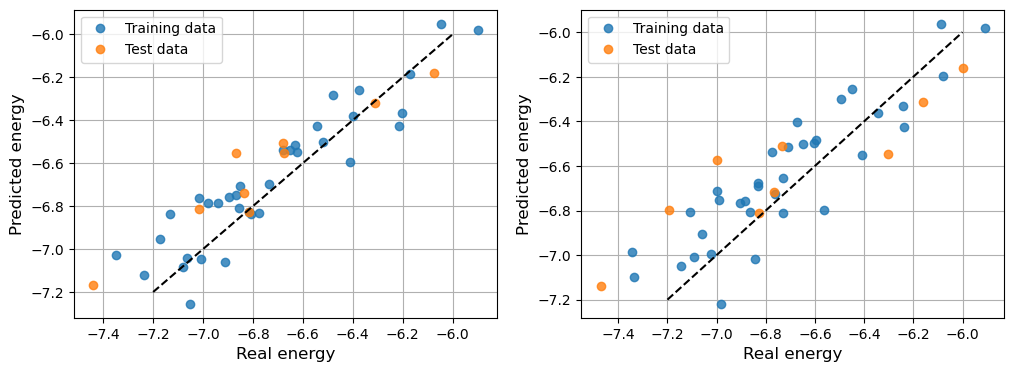

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
xs = np.linspace(-7.2,-6, 100)
with torch.no_grad():
    for model, ax, data_loaders in zip(models, axs, data_loaders_total):
        train_loader, test_loader = data_loaders
        for i, graphs in enumerate(train_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8, label="Training data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8)
        for i, graphs in enumerate(test_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8, label="Test data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8)
        ax.grid()
        ax.plot(xs, xs, '--',c="k")
        ax.set_xlabel("Real energy", fontsize=12)
        ax.set_ylabel("Predicted energy", fontsize=12)
        ax.legend()

In [21]:
class GCNN_layered_acc(MessagePassing):
    def __init__(self, d_in, d_out, hidden_dims=[(7,7),(7,7)], activation_func=torch.nn.SiLU(), aggr='add'): 
        super().__init__(aggr=aggr)
        self.psi_hiddens = torch.nn.ParameterList()
        self.phi_hiddens = torch.nn.ParameterList()
        self.num_layers = len(hidden_dims)
        if self.num_layers == 0:
            self.input_psi = (torch.nn.Linear(d_in, d_out, bias=True))
            self.input_phi = (torch.nn.Linear(d_in+d_out, d_out, bias=True))
        else:
            for i, hidden_layer in enumerate(hidden_dims):
                d_in_hidden, d_out_hidden = hidden_layer
                if i == 0:
                    self.input_psi = torch.nn.Linear(d_in, d_in_hidden, bias=True)
                    self.input_phi = torch.nn.Linear(d_in + d_in_hidden, d_in_hidden, bias=True)
                self.psi_hiddens.append(torch.nn.Linear(d_in_hidden, d_out_hidden, bias=True))
                self.phi_hiddens.append(torch.nn.Linear(d_in_hidden + d_out_hidden, d_out_hidden, bias=True))
            
            self.output_psi = torch.nn.Linear(d_in_hidden, d_out, bias=True)
            self.output_phi = torch.nn.Linear(d_in_hidden + d_out, d_out, bias=True)

        
        self.aggr = SumAggregation()
        self.activation_func = activation_func
        
    def forward(self, x, edge_index, batch):
        psi_of_x_j = self.propagate(edge_index, x=x, psi=self.input_psi)
        x = self.activation_func(self.input_phi(torch.hstack((x, psi_of_x_j))))
        for psi, phi in zip(self.psi_hiddens, self.phi_hiddens):
            psi_of_x_j = self.propagate(edge_index, x=x, psi=psi)
            x = self.activation_func(phi(torch.hstack((x, psi_of_x_j)))) #Not sure where to put the activation function? It says in between layers? So should be here?
        psi_of_x_j = self.propagate(edge_index, x=x, psi=self.output_psi)
        x = self.output_phi(torch.hstack((x, psi_of_x_j)))
        y = self.aggr(x, batch)
        return x, y # return both local and global prediction

    def message(self, x_j, psi):
        return psi(x_j)

In [22]:
data_loaders_total = [get_data_and_loaders(MODIFIED=True, batch_sizes=(5,1)), get_data_and_loaders(MODIFIED=False, batch_sizes=(5,1))]
models = [GCNN_layered_acc(1,1,[(7,7),(7,7)]) for i in range(2)]
labels = ["Training on MODIFIED Data:", "Training on UN-MODIFIED Data:"]
for model, data_loaders, label in zip(models, data_loaders_total, labels):
    print(label)
    train_loader, test_loader = data_loaders
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, epochs=4000)
    print("")

Training on MODIFIED Data:
Epoch 250/4000, Loss: 0.0281
Epoch 500/4000, Loss: 0.0149
Epoch 750/4000, Loss: 0.0167
Epoch 1000/4000, Loss: 0.0156
Epoch 1250/4000, Loss: 0.0132
Epoch 1500/4000, Loss: 0.0114
Epoch 1750/4000, Loss: 0.0108
Epoch 2000/4000, Loss: 0.0105
Epoch 2250/4000, Loss: 0.0063
Epoch 2500/4000, Loss: 0.0054
Epoch 2750/4000, Loss: 0.0044
Epoch 3000/4000, Loss: 0.0054
Epoch 3250/4000, Loss: 0.0065
Epoch 3500/4000, Loss: 0.0015
Epoch 3750/4000, Loss: 0.0012
Epoch 4000/4000, Loss: 0.0006

Training on UN-MODIFIED Data:
Epoch 250/4000, Loss: 0.0355
Epoch 500/4000, Loss: 0.0305
Epoch 750/4000, Loss: 0.0423
Epoch 1000/4000, Loss: 0.0255
Epoch 1250/4000, Loss: 0.0225
Epoch 1500/4000, Loss: 0.0209
Epoch 1750/4000, Loss: 0.0195
Epoch 2000/4000, Loss: 0.0170
Epoch 2250/4000, Loss: 0.0163
Epoch 2500/4000, Loss: 0.0103
Epoch 2750/4000, Loss: 0.0109
Epoch 3000/4000, Loss: 0.0097
Epoch 3250/4000, Loss: 0.0098
Epoch 3500/4000, Loss: 0.0089
Epoch 3750/4000, Loss: 0.0102
Epoch 4000/4000, L

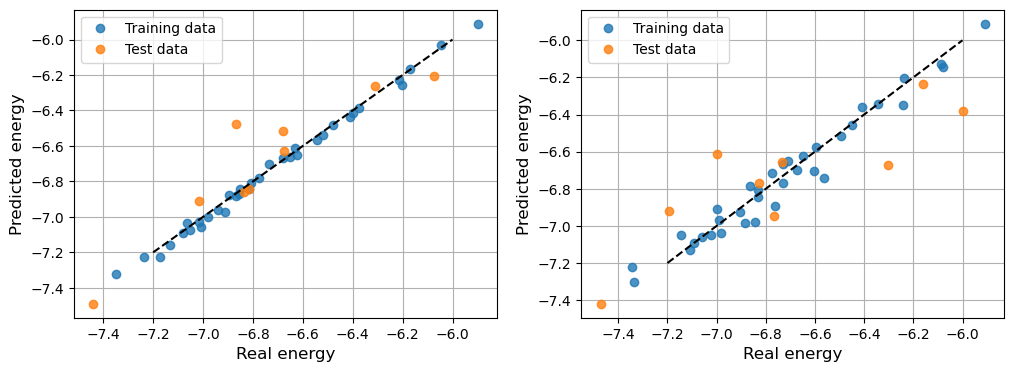

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
xs = np.linspace(-7.2,-6, 100)
with torch.no_grad():
    for model, ax, data_loaders in zip(models, axs, data_loaders_total):
        train_loader, test_loader = data_loaders
        for i, graphs in enumerate(train_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8, label="Training data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8)
        for i, graphs in enumerate(test_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8, label="Test data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8)
        ax.grid()
        ax.plot(xs, xs, '--',c="k")
        ax.set_xlabel("Real energy", fontsize=12)
        ax.set_ylabel("Predicted energy", fontsize=12)
        ax.legend()

In [27]:
class GCNN_layered_acc(MessagePassing):
    def __init__(self, d_in, d_out, hidden_dims=[(7,7),(7,7)], activation_func=torch.nn.SiLU(), head_layer_dims=[(1,7), (7,1)],aggr='add'): 
        super().__init__(aggr=aggr)
        self.psi_hiddens = torch.nn.ParameterList()
        self.phi_hiddens = torch.nn.ParameterList()
        self.head_layers = torch.nn.ParameterList()
        self.num_layers = len(hidden_dims)
        if self.num_layers == 0:
            self.input_psi = (torch.nn.Linear(d_in, d_out, bias=True))
            self.input_phi = (torch.nn.Linear(d_in+d_out, d_out, bias=True))
        else:
            for i, hidden_layer in enumerate(hidden_dims):
                d_in_hidden, d_out_hidden = hidden_layer
                if i == 0:
                    self.input_psi = torch.nn.Linear(d_in, d_in_hidden, bias=True)
                    self.input_phi = torch.nn.Linear(d_in + d_in_hidden, d_in_hidden, bias=True)
                self.psi_hiddens.append(torch.nn.Linear(d_in_hidden, d_out_hidden, bias=True))
                self.phi_hiddens.append(torch.nn.Linear(d_in_hidden + d_out_hidden, d_out_hidden, bias=True))
            
            self.output_psi = torch.nn.Linear(d_in_hidden, d_out, bias=True)
            self.output_phi = torch.nn.Linear(d_in_hidden + d_out, d_out, bias=True)

        for head_layer in head_layer_dims:
            in_dims, out_dims = head_layer
            self.head_layers.append(torch.nn.Linear(in_dims, out_dims, bias=True))
        
        self.aggr = SumAggregation()
        self.activation_func = activation_func
        
    def forward(self, x, edge_index, batch):
        psi_of_x_j = self.propagate(edge_index, x=x, psi=self.input_psi)
        x = self.activation_func(self.input_phi(torch.hstack((x, psi_of_x_j))))
        for psi, phi in zip(self.psi_hiddens, self.phi_hiddens):
            psi_of_x_j = self.propagate(edge_index, x=x, psi=psi)
            x = self.activation_func(phi(torch.hstack((x, psi_of_x_j)))) #Not sure where to put the activation function? It says in between layers? So should be here?
        psi_of_x_j = self.propagate(edge_index, x=x, psi=self.output_psi)
        x = self.output_phi(torch.hstack((x, psi_of_x_j)))
        
        for i, layer in enumerate(self.head_layers):
            if i < len(self.head_layers)-1:
                x = self.activation_func(layer(x))
            else:
                x = layer(x)

        y = self.aggr(x, batch)
        return x, y # return both local and global prediction

    def message(self, x_j, psi):
        return psi(x_j)

In [30]:
data_loaders_total = [get_data_and_loaders(MODIFIED=True, batch_sizes=(5,1)), get_data_and_loaders(MODIFIED=False, batch_sizes=(5,1))]
models = [GCNN_layered_acc(1,1,[(7,7),(7,7)], head_layer_dims=[(1,7), (7,7), (7,1)]) for i in range(2)]
labels = ["Training on MODIFIED Data:", "Training on UN-MODIFIED Data:"]
for model, data_loaders, label in zip(models, data_loaders_total, labels):
    print(label)
    train_loader, test_loader = data_loaders
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, epochs=6000)
    print("")

Training on MODIFIED Data:
Epoch 250/6000, Loss: 0.0216
Epoch 500/6000, Loss: 0.0150
Epoch 750/6000, Loss: 0.0216
Epoch 1000/6000, Loss: 0.0114
Epoch 1250/6000, Loss: 0.0102
Epoch 1500/6000, Loss: 0.0073
Epoch 1750/6000, Loss: 0.0068
Epoch 2000/6000, Loss: 0.0031
Epoch 2250/6000, Loss: 0.0058
Epoch 2500/6000, Loss: 0.0028
Epoch 2750/6000, Loss: 0.0013
Epoch 3000/6000, Loss: 0.0006
Epoch 3250/6000, Loss: 0.0006
Epoch 3500/6000, Loss: 0.0004
Epoch 3750/6000, Loss: 0.0007
Epoch 4000/6000, Loss: 0.0002
Epoch 4250/6000, Loss: 0.0022
Epoch 4500/6000, Loss: 0.0003
Epoch 4750/6000, Loss: 0.0004
Epoch 5000/6000, Loss: 0.0001
Epoch 5250/6000, Loss: 0.0001
Epoch 5500/6000, Loss: 0.0001
Epoch 5750/6000, Loss: 0.0001
Epoch 6000/6000, Loss: 0.0002

Training on UN-MODIFIED Data:
Epoch 250/6000, Loss: 0.0570
Epoch 500/6000, Loss: 0.0294
Epoch 750/6000, Loss: 0.0203
Epoch 1000/6000, Loss: 0.0196
Epoch 1250/6000, Loss: 0.0188
Epoch 1500/6000, Loss: 0.0235
Epoch 1750/6000, Loss: 0.0199
Epoch 2000/6000, L

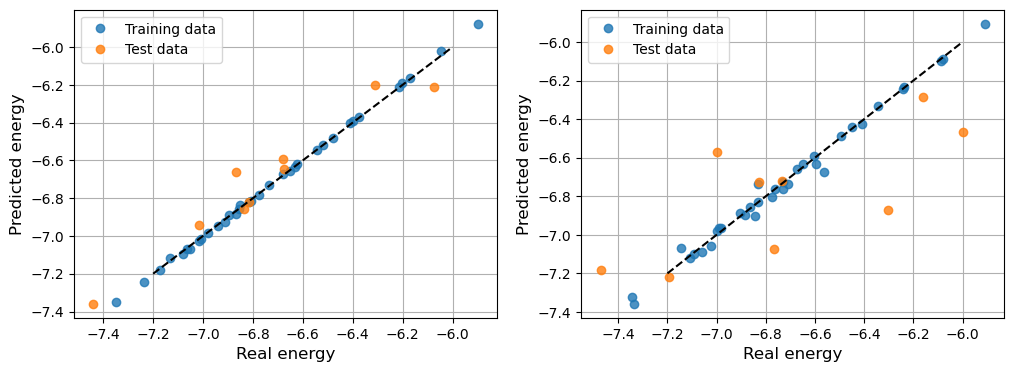

In [31]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
xs = np.linspace(-7.2,-6, 100)
with torch.no_grad():
    for model, ax, data_loaders in zip(models, axs, data_loaders_total):
        train_loader, test_loader = data_loaders
        for i, graphs in enumerate(train_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8, label="Training data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C0", alpha=0.8)
        for i, graphs in enumerate(test_loader):
            _, y_pred = model.forward(x=graphs.x, edge_index=graphs.edge_index, batch=graphs.batch)
            if i == 0:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8, label="Test data")
            else:
                ax.plot(graphs.y, y_pred, 'o', c="C1", alpha=0.8)
        ax.grid()
        ax.plot(xs, xs, '--',c="k")
        ax.set_xlabel("Real energy", fontsize=12)
        ax.set_ylabel("Predicted energy", fontsize=12)
        ax.legend()

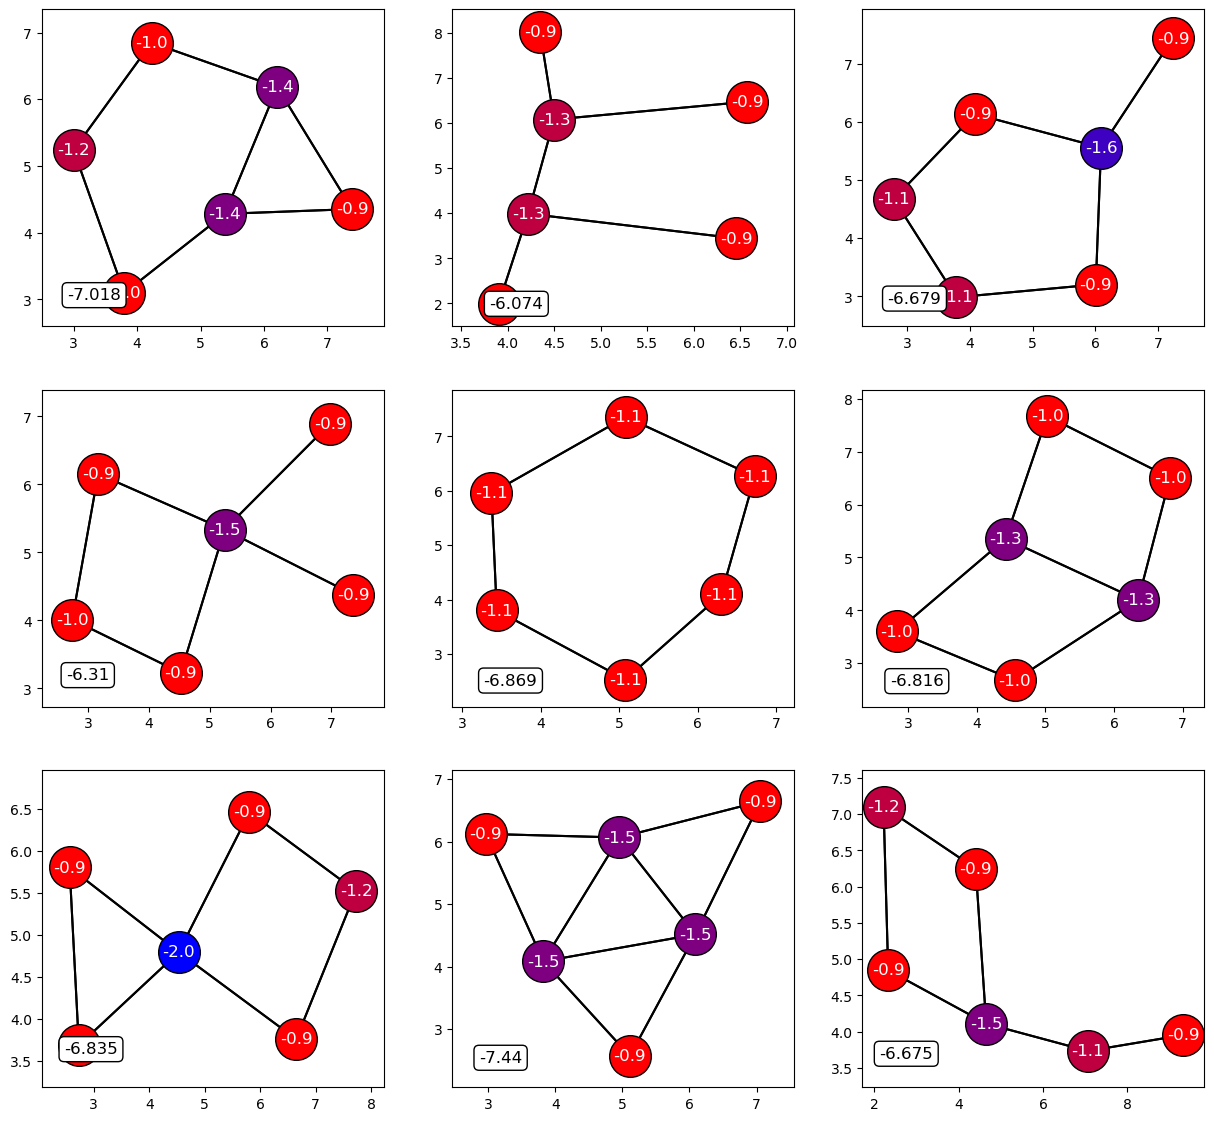

In [33]:
train_loader, test_loader = get_data_and_loaders(MODIFIED=True)
fig, axs = plt.subplots(3,3, figsize=(15,14))
cnorm, cmap = get_cmap_colors(graphs=None, model=None, max_val=0.0, min_val=-2.0)
for graph, ax in zip(test_loader, axs.flatten()):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm, model=models[0])